# Variantional Autoencoder (VAE)

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
sess = tf.Session()

In [4]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    l_border = -constant * np.sqrt(6.0 / (fan_in + fan_out)) 
    h_border = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=l_border, maxval=h_border, dtype=tf.float32)

In [5]:
def fc_layer(name, prev, W, b, type):
    activ = {
        'relu': tf.nn.relu,
        'softmax': tf.nn.softmax,
        'sigmoid': tf.nn.sigmoid,
        'identity': tf.identity
    }
    
    with tf.variable_scope(name):
        prev = tf.matmul(prev, tf.Variable(W, name='W'), name='fc')
        prev = tf.nn.bias_add(prev, tf.Variable(b, name='b'), name='bias')
        prev = activ[type](prev, name='relu')
    return prev

In [6]:
h_image, w_image = 28, 28 
n_input = h_image * w_image

In [7]:
batch_size = 100

In [8]:
class VAE():
    def __init__(self, n_input, n_latent, batch_size):
        self.n_input = n_input
        self.n_latent = n_latent
        
        self.t_input = tf.placeholder(tf.float32, [None, n_input])
        
        with tf.variable_scope('encoder'):
            self.t_mu, self.t_sigma_log_sq = self.__encoder(self.t_input)
            
        eps = tf.random_normal([batch_size, n_latent], 0, 1, dtype=tf.float32)
        self.t_latent = tf.add(self.t_mu, tf.mul(tf.exp(0.5 * self.t_sigma_log_sq), eps))
            
        with tf.variable_scope('decoder'):
            self.t_reconstr = self.__decoder(self.t_latent)
            
        self.t_cost, self.t_train = self.__loss()
    
    def __encoder(self, prev):
        W = xavier_init(self.n_input, 500)
        b = tf.zeros([500], dtype=tf.float32)
        prev = fc_layer('fc1', prev, W=W, b=b, type='relu')
    
        W = xavier_init(500, 500)
        b = tf.zeros([500], dtype=tf.float32)
        prev = fc_layer('fc2', prev, W=W, b=b, type='relu')
        
        W_mu = xavier_init(500, self.n_latent)
        b_mu = tf.zeros([self.n_latent], dtype=tf.float32)
        t_mu = fc_layer('mean', prev, W=W_mu, b=b_mu, type='identity')

        W_sigma_log_sq = xavier_init(500, self.n_latent)
        b_sigma_log_sq = tf.zeros([self.n_latent], dtype=tf.float32)
        t_sigma_log_sq = fc_layer('sigma_log', prev, W=W_sigma_log_sq, b=b_sigma_log_sq, type='identity')
        
        return t_mu, t_sigma_log_sq
    
    def __decoder(self, prev):
        W = xavier_init(self.n_latent, 500)
        b = tf.zeros([500], dtype=tf.float32)
        prev = fc_layer('fc1', prev, W=W, b=b, type='relu')
    
        W = xavier_init(500, 500)
        b = tf.zeros([500], dtype=tf.float32)
        prev = fc_layer('fc2', prev, W=W, b=b, type='relu')
        
        W = xavier_init(500, self.n_input)
        b = tf.zeros([self.n_input], dtype=tf.float32)
        t_reconstr = fc_layer('fc3', prev, W=W, b=b, type='sigmoid')
        
        return t_reconstr
    
    def __loss(self):
        eps = 1e-10
        t_loss_reconstr = -tf.reduce_sum(
            self.t_input * tf.log(self.t_reconstr + eps) \
            + (1.0 - self.t_input) * tf.log(1.0 - self.t_reconstr + eps), 1)
        t_loss_regular = -0.5 * tf.reduce_sum(
            1.0 + self.t_sigma_log_sq - tf.square(self.t_mu) - tf.exp(self.t_sigma_log_sq), 1)

        t_cost = tf.reduce_mean(t_loss_reconstr + t_loss_regular)
        t_train = tf.train.AdamOptimizer(learning_rate=0.001).minimize(t_cost)
        
        return t_cost, t_train

In [9]:
vae_20 = VAE(n_input, 20, batch_size)

In [10]:
def fit(vae, n_epochs):
    init = tf.initialize_all_variables()
    sess.run(init)
    total_batch = int(n_samples / batch_size)
    
    for epoch in range(n_epochs):
        avg_cost = 0.0
    
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            _, cost = sess.run([vae.t_train, vae.t_cost], feed_dict={vae.t_input: batch_xs})
            avg_cost += cost / n_samples * batch_size

        if epoch % 5 == 0:
            print "Epoch: %04d" % (epoch+1), "cost = {:.9f}".format(avg_cost)

In [11]:
fit(vae_20, 75)

Epoch: 0001 cost = 166.587531086
Epoch: 0006 cost = 106.349745927
Epoch: 0011 cost = 102.133143255
Epoch: 0016 cost = 100.213263397
Epoch: 0021 cost = 99.038552454
Epoch: 0026 cost = 98.206388661
Epoch: 0031 cost = 97.634062736
Epoch: 0036 cost = 97.174685183
Epoch: 0041 cost = 96.784579842
Epoch: 0046 cost = 96.372956252
Epoch: 0051 cost = 96.149743736
Epoch: 0056 cost = 95.879431402
Epoch: 0061 cost = 95.641838684
Epoch: 0066 cost = 95.497593606
Epoch: 0071 cost = 95.258151772


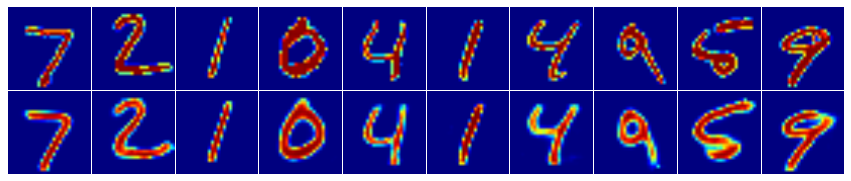

In [12]:
def draw_image(image, ax):
    ax.imshow(image, vmin=0, vmax=1)
    ax.tick_params(
        axis='both', which='both',
        bottom='off', top='off', right='off', left='off',
        labelbottom='off', labelleft='off'
    )
    for spine in ax.spines.values():
        spine.set_edgecolor('#ffffff')

sample, _ = mnist.test.next_batch(100)
sample_re = sess.run(vae_20.t_reconstr, feed_dict={vae_20.t_input: sample})

f, axarr = plt.subplots(2, 10, figsize=(15, 3))
f.subplots_adjust(wspace=0, hspace=0)

for i in range(10):
    draw_image(sample[i].reshape(h_image, w_image), axarr[0, i])
    draw_image(sample_re[i].reshape(h_image, w_image), axarr[1, i])


In [13]:
vae_2 = VAE(n_input, 2, batch_size)

In [14]:
fit(vae_2, 75)

Epoch: 0001 cost = 182.713451982
Epoch: 0006 cost = 150.553899203
Epoch: 0011 cost = 146.214351945
Epoch: 0016 cost = 143.480875827
Epoch: 0021 cost = 141.729183794
Epoch: 0026 cost = 141.091423423
Epoch: 0031 cost = 140.010178999
Epoch: 0036 cost = 139.508597024
Epoch: 0041 cost = 138.864501828
Epoch: 0046 cost = 138.382909823
Epoch: 0051 cost = 138.317857167
Epoch: 0056 cost = 137.789135978
Epoch: 0061 cost = 137.492149270
Epoch: 0066 cost = 136.810421739
Epoch: 0071 cost = 136.489753349


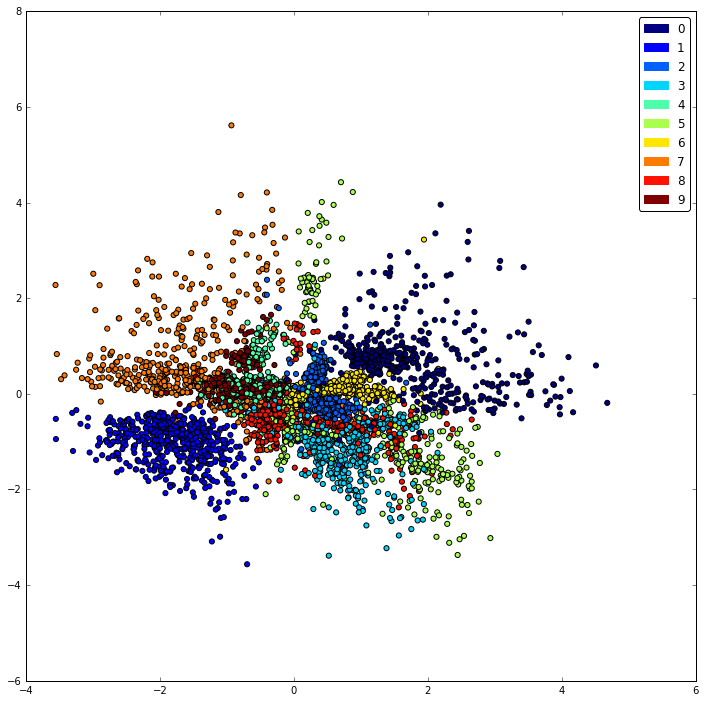

In [15]:
import matplotlib.patches as mpatches

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = sess.run(vae_2.t_mu, feed_dict={vae_2.t_input: x_sample})

colormap = plt.cm.jet(np.linspace(0, 1, 10))

plt.figure(figsize=(12, 12)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], s=26, c=map(lambda x: colormap[x], np.argmax(y_sample, 1)))

handles = [mpatches.Circle((0,0), label=i, color=colormap[i]) for i in range(10)]
plt.legend(handles=handles, fancybox=True, loc='best')

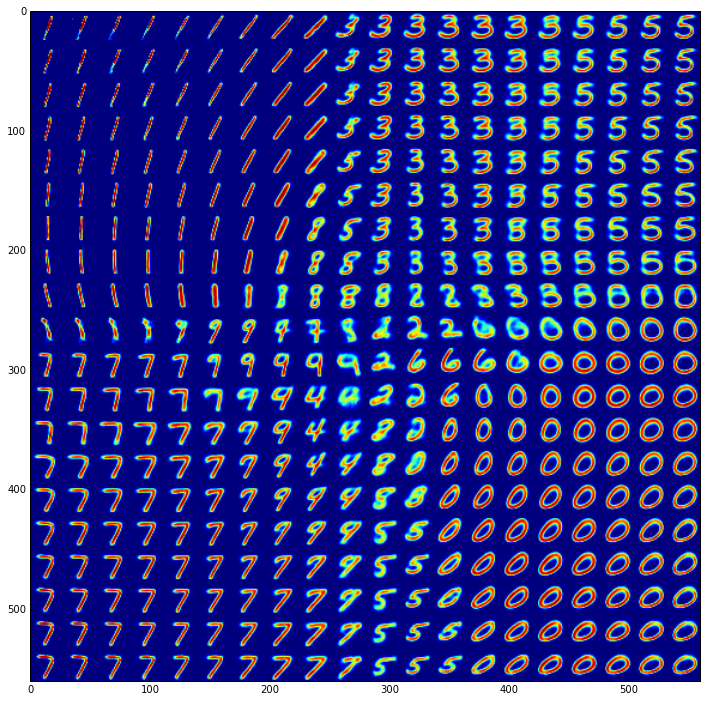

In [16]:
n = 20
figure = np.zeros((h_image * n, w_image * n))

grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        x_decoded = sess.run(vae_2.t_reconstr, feed_dict={vae_2.t_latent: np.asarray([[xi, yi]] * batch_size)})
        digit = x_decoded[0].reshape(h_image, w_image)
        figure[i * h_image: (i + 1) * h_image,
               j * w_image: (j + 1) * w_image] = digit

plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()